# U-Net for Brain Tumor Segmentation

## 1. Set up

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchio as tio
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset, sampler
from models.unet_model import UNet  # Import the UNet model

C:\Users\baoro\AppData\Local\Temp\ipykernel_30852\1060290808.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\baoro\miniconda3\envs\aspp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load Data

In [2]:
X_train, y_train = torch.load("data/brats_train.pt")
X_val, y_val = torch.load("data/brats_val.pt")
X_test, y_test = torch.load("data/brats_test.pt")

## 3. Preprocess

In [3]:
class BraTSDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]  # (C, H, W), already normalized
        mask = self.y[idx]  # (H, W)


        if torch.any(mask > 3):
            print(f"⚠️ Sample {idx} has label > 3. Clamping.")
            mask = torch.clamp(mask, 0, 3)

        if self.transform:
            # Add a singleton Z dimension for TorchIO transforms (C, H, W) -> (C, H, W, 1)
            # TorchIO expects 4D tensors (C, H, W, D) or (C, D, H, W)
            img_4d = img.unsqueeze(-1)
            # Apply the transform
            img_transformed_4d = self.transform(img_4d)
            # Remove the singleton Z dimension (C, H, W, 1) -> (C, H, W)
            img = img_transformed_4d.squeeze(-1)

        return img, mask

In [4]:
# Define TorchIO transforms
transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1), percentiles=(0.5, 99.5)), # Normalize intensity
    # tio.RandomFlip(axes=('LR',)), # Example augmentation: Random horizontal flip
    # tio.RandomAffine(scales=(0.9, 1.1), degrees=10), # Example augmentation: Random scaling and rotation
    # Add other relevant TorchIO transforms here
])

# Create datasets
train_dataset = BraTSDataset(X_train, y_train, transform=transform) # Apply transform only to training data
val_dataset = BraTSDataset(X_val, y_val)
test_dataset = BraTSDataset(X_test, y_test)

# Verify dataset output
try:
    img, mask = train_dataset[0]
    print(f'Sample 0 - Image shape: {img.shape}, Mask shape: {mask.shape}')
    print(f'Image dtype: {img.dtype}, Mask dtype: {mask.dtype}')
    print(f'Image value range: [{img.min()}, {img.max()}]')
    print(f'Unique mask values: {torch.unique(mask)}')
except IndexError:
     print("Could not get sample from dataset. Check data loading.")

Sample 0 - Image shape: torch.Size([3, 128, 128]), Mask shape: torch.Size([128, 128])
Image dtype: torch.float32, Mask dtype: torch.int64
Image value range: [0.0, 1.0]
Unique mask values: tensor([0])


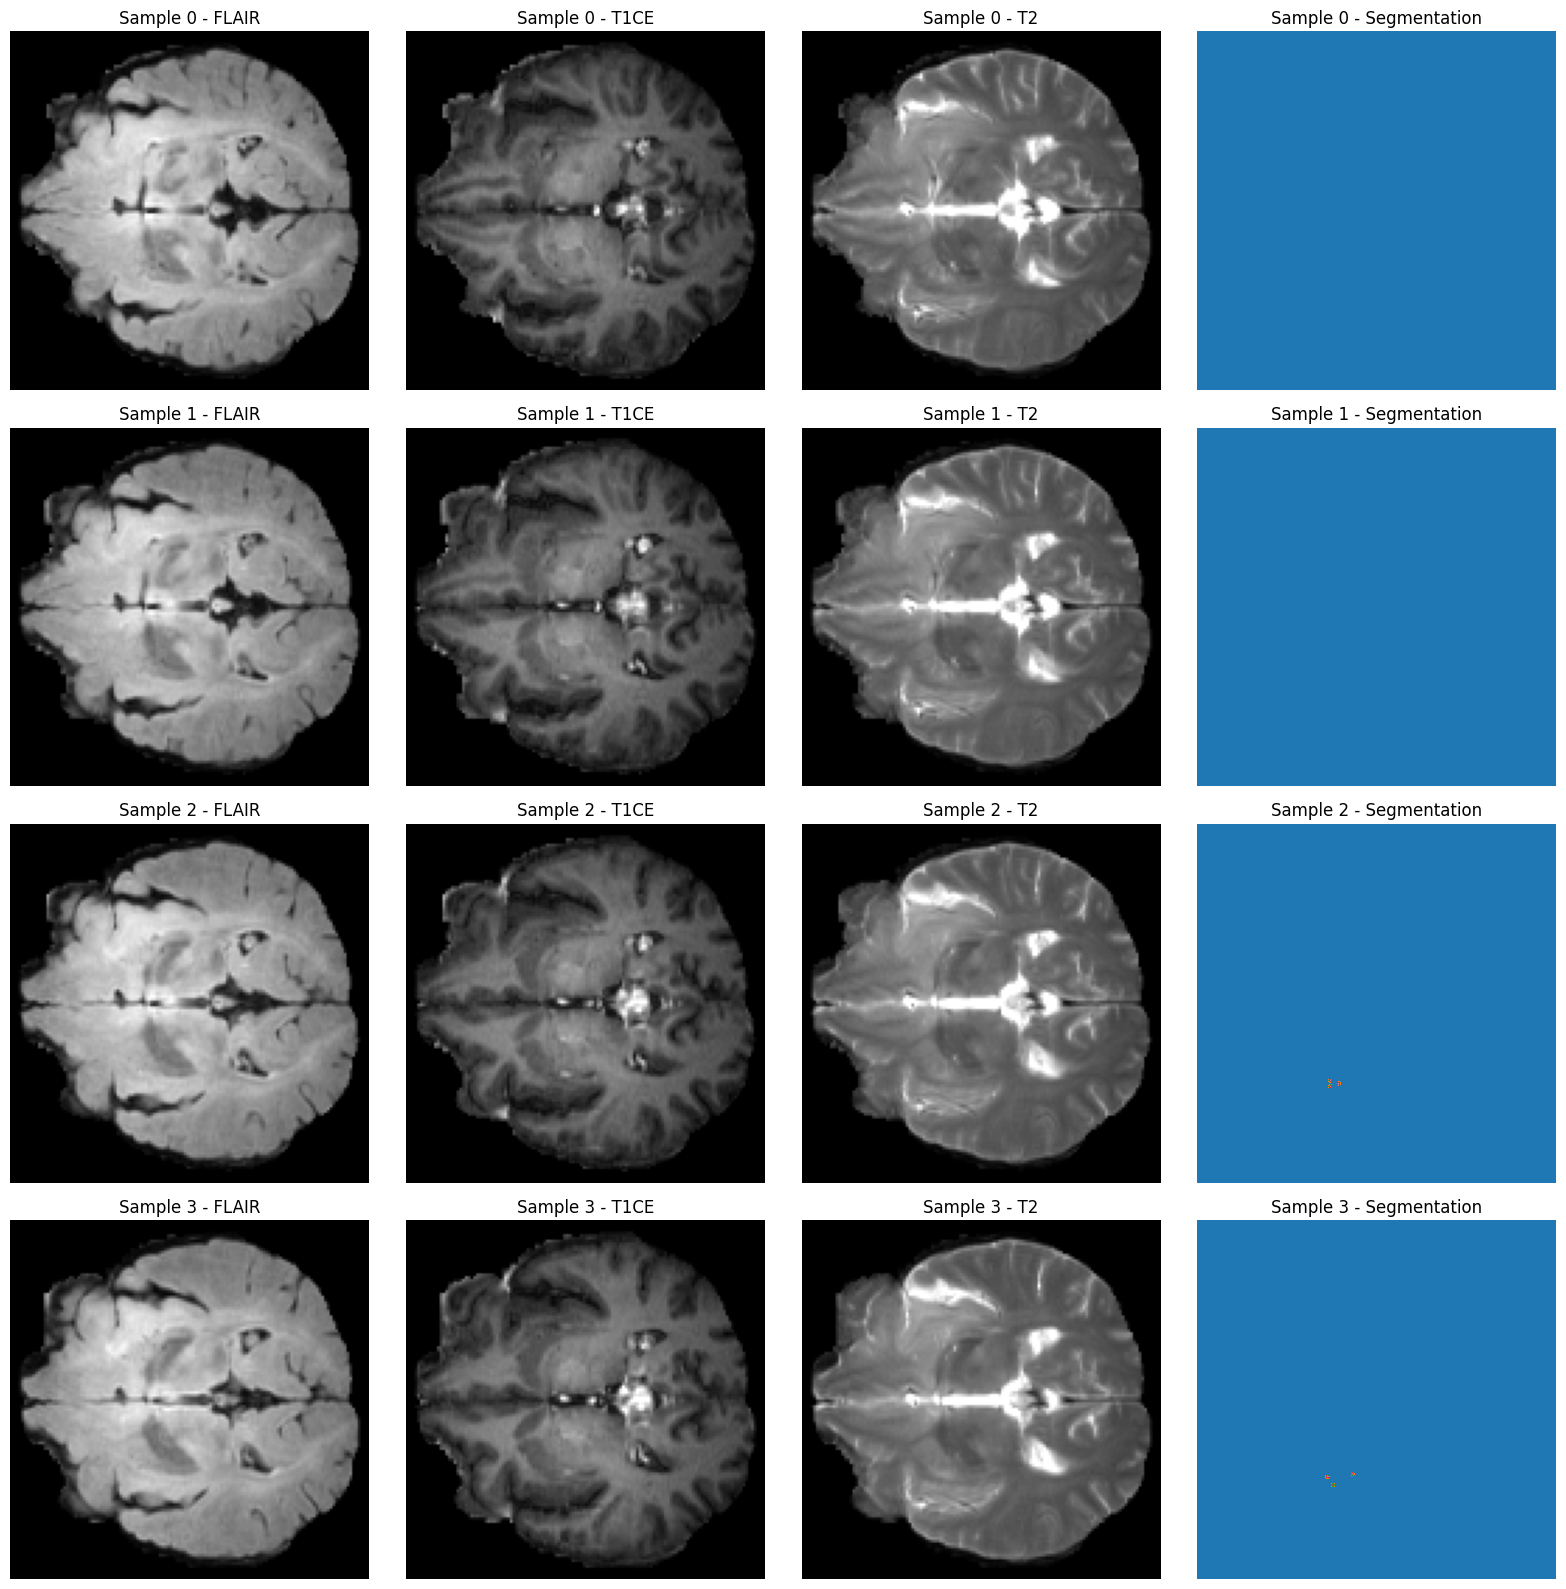

In [5]:
def plot_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))  # 3 inputs + 1 mask
    if num_samples > len(dataset):
        print(f"Warning: Requested {num_samples} samples, but dataset only has {len(dataset)}.")
        num_samples = len(dataset)
    if num_samples == 0:
        print("No samples to plot.")
        return

    for i in range(num_samples):
        img, mask = dataset[i]
        # img: (3, H, W), mask: (1, H, W)
        img = img.cpu().numpy()
        mask = mask.squeeze().cpu().numpy() # Squeeze channel dim for plotting

        # Assuming channel order: FLAIR, T1CE, T2
        flair = img[0]
        t1ce = img[1]
        t2 = img[2]

        axes[i, 0].imshow(flair, cmap='gray')
        axes[i, 0].set_title(f'Sample {i} - FLAIR')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(t1ce, cmap='gray')
        axes[i, 1].set_title(f'Sample {i} - T1CE')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(t2, cmap='gray')
        axes[i, 2].set_title(f'Sample {i} - T2')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(mask, cmap='tab10', vmin=0, vmax=3) # Use tab10 colormap, set vmin/vmax
        axes[i, 3].set_title(f'Sample {i} - Segmentation')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()

# Plot samples from the training dataset
plot_samples(train_dataset, num_samples=4)

## 5. Loss Function and Metrics

In [ ]:
def dice_coeff(pred, target, smooth=1e-6):
    """Calculates Dice Coefficient for multi-class segmentation."""
    num_classes = pred.shape[1]
    pred_probs = F.softmax(pred, dim=1)
    pred_masks = F.one_hot(torch.argmax(pred_probs, dim=1), num_classes).permute(0, 3, 1, 2).float()
    target_masks = F.one_hot(target.squeeze(1), num_classes).permute(0, 3, 1, 2).float()

    intersection = torch.sum(pred_masks * target_masks, dim=(2, 3))
    union = torch.sum(pred_masks, dim=(2, 3)) + torch.sum(target_masks, dim=(2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean() # Average Dice across batch and classes

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, pred, target):
        return 1 - dice_coeff(pred, target)

class DiceCELoss(nn.Module):
    """Combines Dice Loss and Cross Entropy Loss."""
    def __init__(self, dice_weight=0.5, ce_weight=0.5, class_weights=None, ignore_index=-100):
        super(DiceCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        self.dice_loss = DiceLoss()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=ignore_index)

    def forward(self, pred, target):
        target_long_squeezed = target.squeeze(1).long()
        dice = self.dice_loss(pred, target)
        ce = self.ce_loss(pred, target_long_squeezed)
        return self.dice_weight * dice + self.ce_weight * ce

def iou_score(pred, target, smooth=1e-6):
    """Calculates Intersection over Union (IoU) for multi-class segmentation."""
    num_classes = pred.shape[1]
    pred_probs = F.softmax(pred, dim=1)
    pred_masks = F.one_hot(torch.argmax(pred_probs, dim=1), num_classes).permute(0, 3, 1, 2).float()
    target_masks = F.one_hot(target.squeeze(1), num_classes).permute(0, 3, 1, 2).float()

    intersection = torch.sum(pred_masks * target_masks, dim=(2, 3))
    union = torch.sum(pred_masks, dim=(2, 3)) + torch.sum(target_masks, dim=(2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean() # Average IoU across batch and classes

## 6. Training and Testing Functions

In [13]:
# Enable mixed precision training for memory efficiency
use_amp = True  # Set to False if you encounter numerical instability
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# Update your train_epoch function
def train_epoch(model, loader, optimizer, criterion, device, dtype):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = len(loader)
    
    for inputs, labels in loader:
        inputs = inputs.to(device, dtype=dtype, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Use automatic mixed precision for forward pass
        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Scale loss and perform backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        with torch.no_grad():
            iou = iou_score(outputs, labels)
            dice = dice_coeff(outputs, labels)
            
        total_loss += loss.item()
        total_iou += iou.item()
        total_dice += dice.item()
    
    return total_loss/num_batches, total_iou/num_batches, total_dice/num_batches

def evaluate(model, loader, criterion, device, dtype):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_dice = 0.0
    num_batches = len(loader)

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device, dtype=dtype)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            iou = iou_score(outputs, labels)
            dice = dice_coeff(outputs, labels)

            total_loss += loss.item()
            total_iou += iou.item()
            total_dice += dice.item()

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    avg_dice = total_dice / num_batches
    return avg_loss, avg_iou, avg_dice

## 7. Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

dtype = torch.float32
save_path = 'checkpoints/unet_brats_dce_adam.pth'
print_every = 1

input_channels = 3 # FLAIR, T1CE, T2
num_classes = 4    # Background, Necrotic core, Edema, Enhancing tumor
batch_size = 4     # Adjust based on GPU memory
num_epochs = 10    # Number of training epochs (adjust as needed)
learning_rate = 1e-4

model = UNet(n_channels=input_channels, n_classes=num_classes, bilinear=True)
model = model.to(device)
class_weights = torch.tensor([1.0, 10.0, 5.0, 8.0]).to(device, dtype=dtype) # Example weights

criterion = DiceCELoss(dice_weight=0.5, ce_weight=0.5, class_weights=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

batch_size = 8
num_workers = 0

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=num_workers > 0,
    prefetch_factor=2 if num_workers > 0 else None
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True,
    persistent_workers=num_workers > 0,
    prefetch_factor=2 if num_workers > 0 else None
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True
)

print(f"CUDA available: {torch.cuda.is_available()}, Device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current device: {torch.cuda.get_device_name(0)}")
    print(f"Device capability: {torch.cuda.get_device_capability(0)}")
    try:
        x = torch.zeros(1).cuda()
        print("CUDA initialization successful")
    except RuntimeError as e:
        print(f"CUDA initialization failed: {e}")
print(f"Input channels: {input_channels}, Num classes: {num_classes}")
print(f"Batch size: {batch_size}, Epochs: {num_epochs}, LR: {learning_rate}")
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

best_val_iou = -1.0
train_losses, val_losses = [], []
train_ious, val_ious = [], []

for epoch in range(num_epochs):
    train_loss, train_iou, train_dice = train_epoch(model, train_loader, optimizer, criterion, device, dtype)
    val_loss, val_iou, val_dice = evaluate(model, val_loader, criterion, device, dtype)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)

    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Train Dice: {train_dice:.4f}')
        print(f'          | Val Loss:   {val_loss:.4f}, Val IoU:   {val_iou:.4f}, Val Dice:   {val_dice:.4f}')

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(model.state_dict(), save_path)
        print(f'          | Model saved to {save_path} (Val IoU improved to {best_val_iou:.4f})')

print("\nTraining finished.")

CUDA available: True, Device count: 1
Current device: NVIDIA GeForce RTX 3070 Laptop GPU
Device capability: (8, 6)
CUDA initialization successful
Input channels: 3, Num classes: 4
Batch size: 8, Epochs: 10, LR: 0.0001
Training samples: 18675, Validation samples: 5550


c:\Users\baoro\miniconda3\envs\aspp\Lib\site-packages\torchio\transforms\preprocessing\intensity\rescale.py:89: RuntimeWarning: Rescaling image "default_image_name" not possible because all the intensity values are the same
  image.set_data(self.rescale(image.data, mask, image_name))


KeyboardInterrupt: 

## 8. Evaluation on Test Set

In [ ]:
print(f"Loading best model from {save_path}")
best_model = UNet(n_channels=input_channels, n_classes=num_classes, bilinear=True)
try:
    best_model.load_state_dict(torch.load(save_path, map_location=device))
    best_model.to(device)
    print("Model loaded successfully.")

    test_loss, test_iou, test_dice = evaluate(best_model, test_loader, criterion, device, dtype)
    print("\n--- Test Set Evaluation ---")
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test IoU:  {test_iou:.4f}')
    print(f'Test Dice: {test_dice:.4f}')
except FileNotFoundError:
    print(f"Error: Saved model file not found at {save_path}. Cannot evaluate.")
except Exception as e:
    print(f"An error occurred during model loading or evaluation: {e}")

## 9. Visualize Segmentation Results

In [ ]:
def visualize_segmentation_overlay(model, dataloader, num_samples=4, device=torch.device('cuda'), dtype=torch.float32):
    """Create and visualize an overlay of segmentation masks on original images."""
    model.eval()
    if num_samples == 0:
        return
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0) # Ensure axes is always 2D

    dataset = dataloader.dataset
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, mask = dataset[idx] # Get raw sample
            image_tensor = image.unsqueeze(0).to(device, dtype=dtype) # Add batch dim and move to device
            mask_tensor = mask.to(device) # Ground truth mask

            # Generate prediction
            output = model(image_tensor)
            pred_prob = torch.softmax(output, dim=1)
            pred_mask = torch.argmax(pred_prob, dim=1).squeeze(0).cpu().numpy() # (H, W)

            # Prepare for plotting
            image_np = image[0].cpu().numpy() # Use FLAIR channel (index 0) for background
            mask_np = mask.squeeze(0).cpu().numpy() # (H, W)

            # Original Image (FLAIR)
            axes[i, 0].imshow(image_np, cmap='gray')
            axes[i, 0].set_title(f"Sample {idx} - Original (FLAIR)")
            axes[i, 0].axis('off')

            # Ground Truth Overlay
            gt_overlay = np.stack([image_np] * 3, axis=-1) # Grayscale background
            colors = plt.cm.tab10(np.linspace(0, 1, 10))
            for c in range(1, 4): # Classes 1, 2, 3
                gt_overlay[mask_np == c] = 0.5 * gt_overlay[mask_np == c] + 0.5 * colors[c][:3]
            axes[i, 1].imshow(np.clip(gt_overlay, 0, 1))
            axes[i, 1].set_title(f"Ground Truth Overlay")
            axes[i, 1].axis('off')

            # Predicted Overlay
            pred_overlay = np.stack([image_np] * 3, axis=-1)
            for c in range(1, 4):
                pred_overlay[pred_mask == c] = 0.5 * pred_overlay[pred_mask == c] + 0.5 * colors[c][:3]
            axes[i, 2].imshow(np.clip(pred_overlay, 0, 1))
            axes[i, 2].set_title(f"Predicted Overlay")
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
print("Visualizing results on test set...")
vis_loader = DataLoader(test_dataset, batch_size=1, shuffle=False) # Use batch_size=1 for visualization
try:
    visualize_segmentation_overlay(best_model, vis_loader, num_samples=4, device=device, dtype=dtype)
except NameError:
    print("Could not visualize: 'best_model' not defined. Was training successful and the model loaded?")
except Exception as e:
    print(f"An error occurred during visualization: {e}")